# Ejercicio 5.7 (home opcional)

### El gobierno de USA ha contratado a nuestra empresa StayHome para que les desarrollemos una aplicación de predicción de la cantidad de infectados por COVID que pueden haber en los próximos 7 días.

### No han dado los datos reales diarios de casos y muertes desde enero de 2020. 

### Para demostrar la fiabilidad de nuestro producto, deberemos validarlo sobre el mes de marzo e inicios de abril de 2021.

### Deberemos probar dos algoritmos distintos de predicción para ver cual es más fiable.
 
### El fichero a cargar es en formato csv: 5.7.covid.csv 

# 1. Importamos librerias

In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics

# 2. Importamos fichero

In [2]:
PATH = '../Data/'
FILE = '5.7.covid.csv'

In [3]:
covid19_df = pd.read_csv(PATH+FILE, sep = ',')
covid19_df.head(50)

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
5,2020-01-26,5,0
6,2020-01-27,5,0
7,2020-01-28,5,0
8,2020-01-29,5,0
9,2020-01-30,6,0


In [4]:
covid19_df.tail()

,date,cases,deaths
437,2021-04-02,30631753,553554
438,2021-04-03,30695580,554302
439,2021-04-04,30732273,554579
440,2021-04-05,30808897,555109
441,2021-04-06,30870922,556016


# 3. Analisis de la información

In [5]:
covid19_df.describe()

,cases,deaths
count,4.420000e+02,442.000000
mean,9.801312e+06,208294.278281
std,1.030960e+07,168720.951351
min,1.000000e+00,0.000000
25%,1.341233e+06,80011.500000
50%,5.953235e+06,182174.500000
75%,1.719745e+07,310125.500000
max,3.087092e+07,556016.000000


In [6]:
covid19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    442 non-null    object
 1   cases   442 non-null    int64 
 2   deaths  442 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 10.5+ KB


In [7]:
covid19_df.nunique()

date      442
cases     422
deaths    403
dtype: int64

### Incorporación de nuevas columnas para manejar el delta de casos y muertes

In [8]:
covid19_df1 = covid19_df # Se realiza copia del primer DF

casospordia = [covid19_df1['cases'][0]]
casospordia.extend(np.diff(covid19_df1['cases']))

muertespordia = [covid19_df1['deaths'][0]]
muertespordia.extend(np.diff(covid19_df1['deaths']))

covid19_df1['casospordia'] = casospordia # Se crea nueva columna con los casos por dia
covid19_df1['muertespordia'] = muertespordia # Se crea nueva columna con las muertes por dia
covid19_df1

,date,cases,deaths,casospordia,muertespordia
0,2020-01-21,1,0,1,0
1,2020-01-22,1,0,0,0
2,2020-01-23,1,0,0,0
3,2020-01-24,2,0,1,0
4,2020-01-25,3,0,1,0
...,...,...,...,...,...
437,2021-04-02,30631753,553554,69152,961
438,2021-04-03,30695580,554302,63827,748
439,2021-04-04,30732273,554579,36693,277
440,2021-04-05,30808897,555109,76624,530


### Generar nueva columna Fecha para visualización de los datos graficamente

In [9]:
covid19_df1['Fecha'] = pd.to_datetime(covid19_df1['date'], format='%Y/%m/%d')

In [10]:
covid19_df1

,date,cases,deaths,casospordia,muertespordia,Fecha
0,2020-01-21,1,0,1,0,2020-01-21
1,2020-01-22,1,0,0,0,2020-01-22
2,2020-01-23,1,0,0,0,2020-01-23
3,2020-01-24,2,0,1,0,2020-01-24
4,2020-01-25,3,0,1,0,2020-01-25
...,...,...,...,...,...,...
437,2021-04-02,30631753,553554,69152,961,2021-04-02
438,2021-04-03,30695580,554302,63827,748,2021-04-03
439,2021-04-04,30732273,554579,36693,277,2021-04-04
440,2021-04-05,30808897,555109,76624,530,2021-04-05


<AxesSubplot:title={'center':'Casos por dia'}, xlabel='Fecha', ylabel='Casos'>

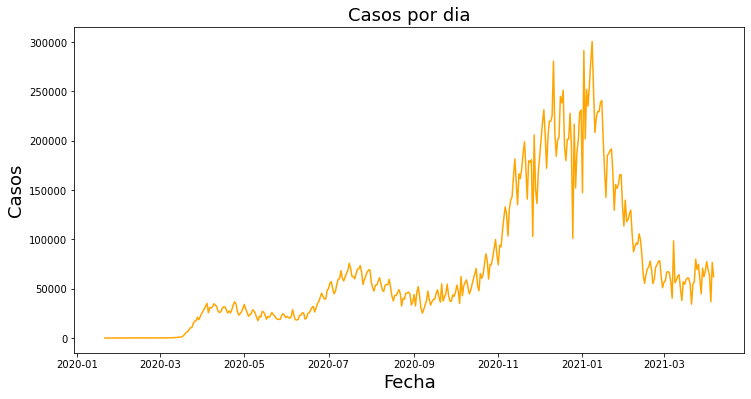

In [11]:
plt.figure(figsize=(12, 6))
plt.title('Casos por dia',fontsize = 18)
plt.ylabel('Casos',fontsize = 18)
plt.xlabel('Fecha',fontsize = 18)
sns.lineplot(data=covid19_df1, x="Fecha", y="casospordia", color='orange')

<AxesSubplot:title={'center':'Histograma Casos por dia'}, xlabel='Casos', ylabel='Count'>

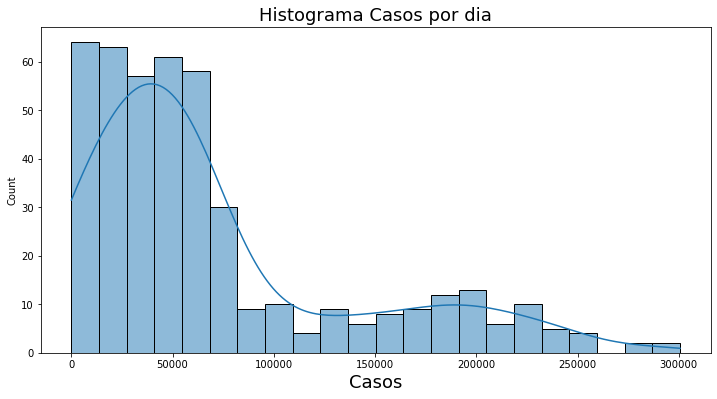

In [12]:
plt.figure(figsize=(12, 6))
plt.title('Histograma Casos por dia',fontsize = 18)
plt.xlabel('Casos',fontsize = 18)
sns.histplot(data=covid19_df1, x="casospordia", kde=True)

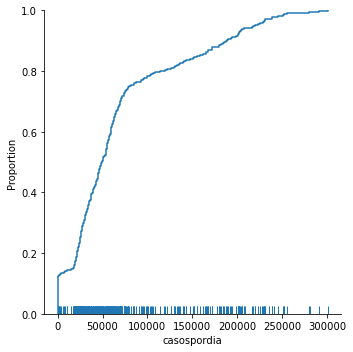

In [13]:
sns.displot(data=covid19_df1, kind="ecdf", x="casospordia",rug=True)

<AxesSubplot:title={'center':'Muertes por dia'}, xlabel='Fecha', ylabel='Muertes'>

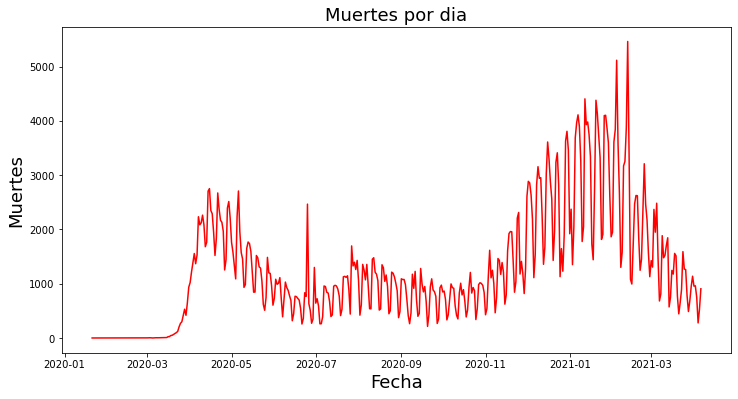

In [14]:
plt.figure(figsize=(12, 6))
plt.title('Muertes por dia',fontsize = 18)
plt.ylabel('Muertes',fontsize = 18)
plt.xlabel('Fecha',fontsize = 18)
sns.lineplot(data=covid19_df1, x="Fecha", y="muertespordia", color='red')

<AxesSubplot:title={'center':'Histograma Muertes por dia'}, xlabel='Muertes', ylabel='Count'>

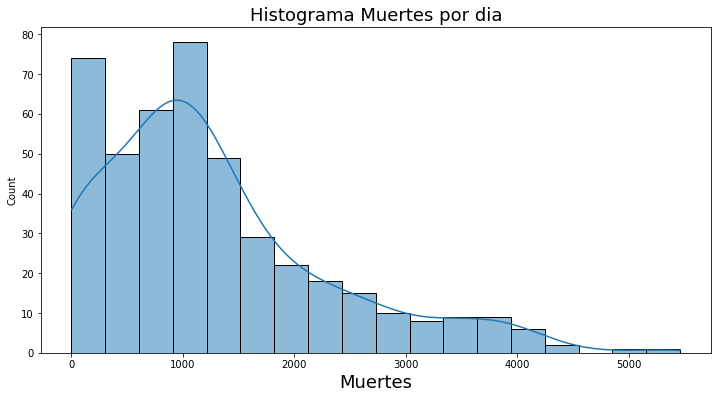

In [15]:
plt.figure(figsize=(12, 6))
plt.title('Histograma Muertes por dia',fontsize = 18)
plt.xlabel('Muertes',fontsize = 18)
sns.histplot(data=covid19_df1, x="muertespordia", kde=True)

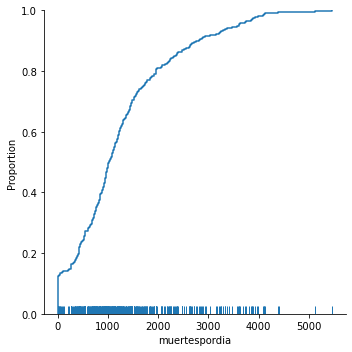

In [16]:
sns.displot(data=covid19_df1, kind="ecdf", x="muertespordia",rug=True)

### Descomponer serie de casos por dia

In [276]:
covid19_casos = covid19_df1[['Fecha','casospordia']]
serie_temporal_covid19_casos = np.array(covid19_casos['casospordia'])
serie_temporal_covid19_casos

array([     1,      0,      0,      1,      1,      2,      0,      0,
            0,      1,      1,      1,      3,      0,      0,      1,
            0,      0,      0,      0,      1,      0,      1,      1,
            0,      0,      0,     10,      0,      0,      2,      3,
            0,      0,     13,      2,     15,      0,      5,      5,
           18,     16,     21,     36,     67,     83,    117,    119,
          201,    270,    245,    405,    556,    674,    702,    907,
         1399,   2444,   4043,   5619,   6516,   8545,  10432,  10433,
        14634,  16998,  17330,  21066,  18520,  21469,  24506,  26930,
        29717,  32318,  35099,  25616,  30916,  30337,  31820,  34699,
        33473,  31720,  27143,  25769,  26691,  30033,  31613,  31509,
        28398,  25334,  27395,  25514,  28831,  33776,  36741,  34408,
        26735,  23197,  24651,  26555,  30357,  33970,  29474,  26140,
        21962,  23709,  24506,  28478,  27648,  24868,  20317,  17621,
      

Text(0.5, 1.0, 'Casos Covid - Descomposición de la serie')

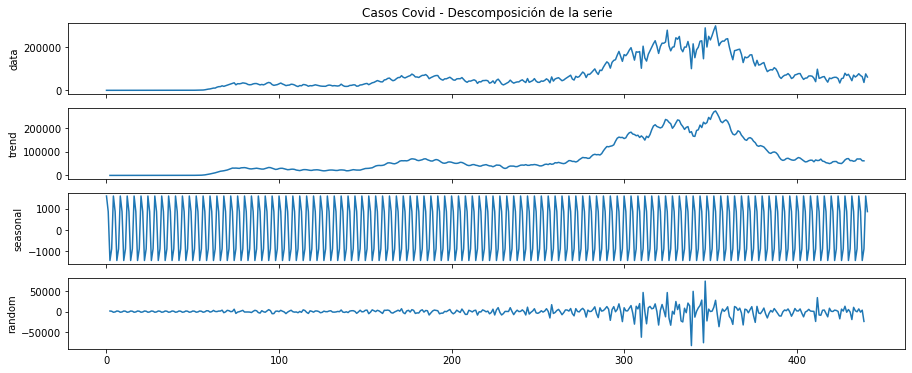

In [18]:
decomposed = arima.decompose(serie_temporal_covid19_casos, 'additive', m=4)

fig = {'figsize': (15, 6)}
axes = utils.decomposed_plot(decomposed, figure_kwargs=fig, show=False)
axes[0].set_title("Casos Covid - Descomposición de la serie")

<b> Se observa estacionalidad segun la descomposición de los casos por dia, para asegurar esta estacionalidad, podemos observar las medias y varianzas de la serie, ademas de generar el Augmented Dickey Fuller Test para comprobarlo

### Variación de Medias y Varianzas

In [19]:
particion = round(len(serie_temporal_covid19_casos)/2)
particion

221

In [20]:
X1,X2 = serie_temporal_covid19_casos[0:particion],serie_temporal_covid19_casos[particion:]
mean1 ,mean2 = X1.mean() , X2.mean()
var1,var2 = X1.var() , X2.var()
print("media_1 = %f , media_2 = %f" %(mean1,mean2))
print("var_1 = %f , var_2 = %f" %(var1,var2))

media_1 = 26836.787330 , media_2 = 112850.642534
var_1 = 462065007.570156 , var_2 = 4904967575.007965


<b> Se ve bastante diferencia entre las varianzas y las medias al divir la serie en dos.

### Usando Augmented Dickey Fuller Test 

In [21]:
resultados = adfuller(serie_temporal_covid19_casos)
print('ADF Statistic: %f' % resultados[0])
print('p-value: %f' % resultados[1])

ADF Statistic: -1.425563
p-value: 0.569962


<b> Con esto podemos concluir que la sere no tiene estacionalidad, primero por la gran diferencia de las varianzas y medias y segundo por tener un p-value mayor a 0.05.

# 4. Modelado de la serie temporal

## 4.1 XGboost

<b> Primero aplicaremos un algoritmo de Machine learning como lo es el xgboost en donde podemos incorporar la serie sin necesidad de aplicar estacionalidad. Para ello generaremos un Fixed partitioning para generar una partición "Train", otra "test" y otra "Valid". Como en el enunciado se pide validar ("valid") con los meses de marzo y principios de abril (37 dias), aplicaremos ese mismo intervalo para los datos de "test".

### Elección de window size y horizon

Window_size =  147


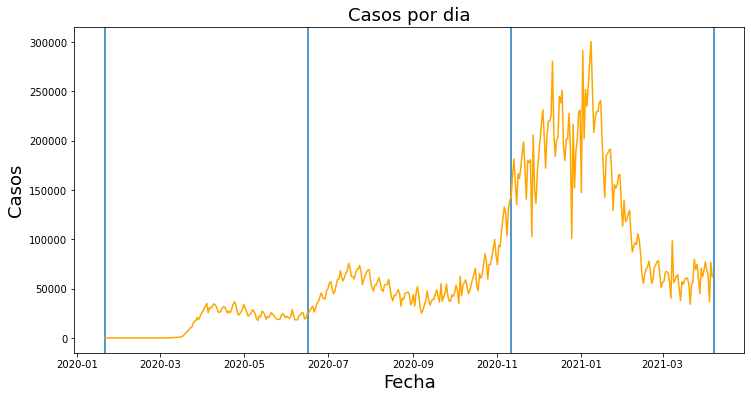

In [22]:
numero_de_windows = 3
windows_size = len(covid19_df1)/numero_de_windows


plt.figure(figsize=(12, 6))
plt.title('Casos por dia',fontsize = 18)
plt.ylabel('Casos',fontsize = 18)
plt.xlabel('Fecha',fontsize = 18)
plt.axvline(x=min(covid19_df1['Fecha']), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*2)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*3)), ymin=0, ymax=1)
sns.lineplot(data=covid19_df1, x="Fecha", y="casospordia", color='orange')
print('Window_size = ', round(windows_size))

Window_size =  74


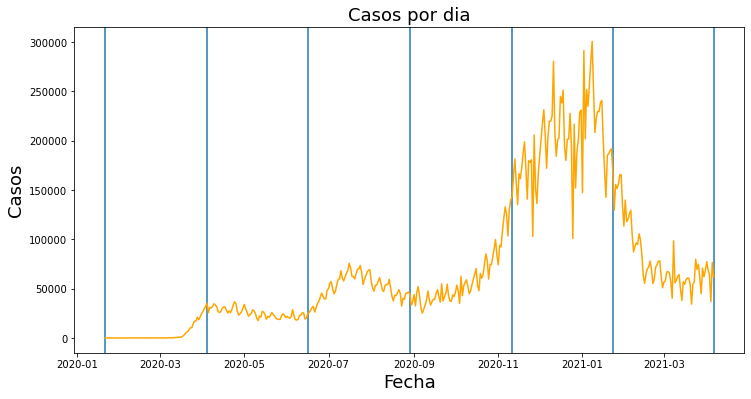

In [23]:
numero_de_windows = 6
windows_size = len(covid19_df1)/numero_de_windows


plt.figure(figsize=(12, 6))
plt.title('Casos por dia',fontsize = 18)
plt.ylabel('Casos',fontsize = 18)
plt.xlabel('Fecha',fontsize = 18)
plt.axvline(x=min(covid19_df1['Fecha']), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*2)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*3)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*4)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*5)), ymin=0, ymax=1)
plt.axvline(x=max(covid19_df1['Fecha']), ymin=0, ymax=1)
sns.lineplot(data=covid19_df1, x="Fecha", y="casospordia", color='orange')
print('Window_size = ', round(windows_size))

Window_size =  37


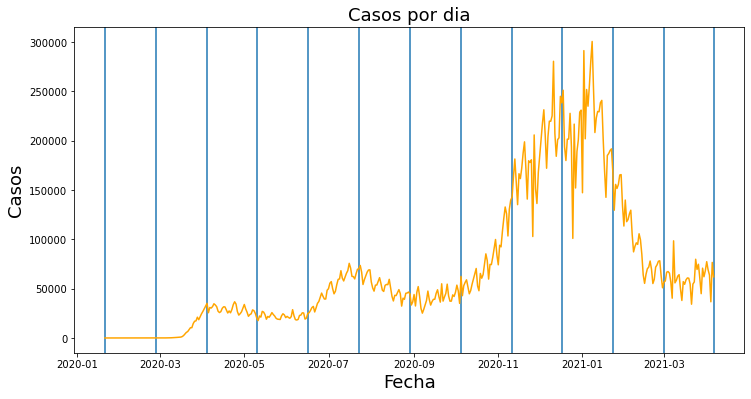

In [24]:
numero_de_windows = 12
windows_size = len(covid19_df1)/numero_de_windows


plt.figure(figsize=(12, 6))
plt.title('Casos por dia',fontsize = 18)
plt.ylabel('Casos',fontsize = 18)
plt.xlabel('Fecha',fontsize = 18)
plt.axvline(x=min(covid19_df1['Fecha']), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*2)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*3)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*4)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*5)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*6)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*7)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*8)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*9)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*10)), ymin=0, ymax=1)
plt.axvline(x=min(covid19_df1['Fecha'])+(datetime.timedelta(days=windows_size*11)), ymin=0, ymax=1)
plt.axvline(x=max(covid19_df1['Fecha']), ymin=0, ymax=1)
sns.lineplot(data=covid19_df1, x="Fecha", y="casospordia", color='orange')
print('Window_size = ', round(windows_size))

<b> Para poder elegir un Windows_size seria ideal elegir con algun concepto de estacionalidad, para en este caso la serie entrego valores que la definen como no es estacional, pero igualmente se puede observar en los graficos alguna similitud estacional si generamos 3 o 6 o 12 ventanas de analisis como se observa (no precisamente pero lo mas parecido). Se eligen las 3 opciones para window size (37,74 y 147), para poder observar el efecto que tienen en el modelo. Ademas se elegira el horizonte de 1 para modelos el XGboost.

### WINDOW_SIZE DE 37

In [25]:
WINDOW_SIZE = 37
HORIZON = 1

df = pd.DataFrame(serie_temporal_covid19_casos, columns = ['Valor'])
df_windowed = df.copy()

list_cols = list(df.columns)
for i in range(1,WINDOW_SIZE+HORIZON):
    
    list_cols.append(list_cols[0]+'-'+str(i))

    df_windowed = pd.concat([df_windowed, df.shift(i)], axis=1)
    
list_cols = ['Target'] + list_cols
list_cols.pop(len(list_cols)-1)
df_windowed.columns = list_cols
df_windowed.dropna(axis=0,inplace=True)

df_windowed.head()

,Target,Valor,Valor-1,Valor-2,Valor-3,Valor-4,Valor-5,Valor-6,Valor-7,Valor-8,...,Valor-27,Valor-28,Valor-29,Valor-30,Valor-31,Valor-32,Valor-33,Valor-34,Valor-35,Valor-36
37,0,15.0,2.0,13.0,0.0,0.0,3.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0
38,5,0.0,15.0,2.0,13.0,0.0,0.0,3.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
39,5,5.0,0.0,15.0,2.0,13.0,0.0,0.0,3.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
40,18,5.0,5.0,0.0,15.0,2.0,13.0,0.0,0.0,3.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
41,16,18.0,5.0,5.0,0.0,15.0,2.0,13.0,0.0,0.0,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0


In [26]:
X = df_windowed.drop(columns = ['Target'], axis = 1)
y = df_windowed['Target']

In [27]:
len_valid = 37
len_test = len_valid

index_train = len(df_windowed) - len_valid - len_test + WINDOW_SIZE - 1
index_test = len(df_windowed) - len_valid + WINDOW_SIZE - 1 

Xtrain, Xtest, Xvalid = X[X.index <= index_train], X[(X.index > index_train) & (X.index <= index_test)], X[X.index > index_test]
ytrain, ytest, yvalid = y[y.index <= index_train], y[(y.index > index_train) & (y.index <= index_test)], y[y.index > index_test]

modelo = GradientBoostingRegressor(random_state=0)
    
modelo.fit(Xtrain, ytrain)
ytrain_pred = modelo.predict(Xtrain)
ypred = modelo.predict(Xtest)
yvalidado = modelo.predict(Xvalid)
print('Predicciones',ypred)
print('Score', modelo.score(Xtrain, ytrain))
print('R2 Score valores predict', r2_score(ypred, ytest))
print('R2 Score valores validación', r2_score(yvalidado, yvalid))
print('mse test', mse(ypred, ytest))
print('mae test', mae(ypred, ytest))
print('mse valid', mse(yvalidado, yvalid))
print('mae valid', mae(yvalidado, yvalid))

Predicciones [144751.70617953 241584.14354463 182599.59007274 229988.34008348
 249062.54621663 270694.22969413 269708.89937848 258208.08805175
 255400.36342651 201742.12211141 217828.94720107 214862.6608045
 217792.22371989 237110.6319972  217616.94818623 192799.80902035
 167536.70261185 159991.07411324 154440.81976037 154931.92958294
 163955.08531459 153704.52745277 122504.25047014 126118.69939005
 132145.13416815 139096.40116783 135785.38498535 131705.20169916
 105059.74013585  70866.46260352  61993.42292203  68462.12833309
  73985.22329869  92831.12758983  89445.91504616  80295.09227228
  67692.36821068]
Score 0.9987825089902175
R2 Score valores predict -0.35830477619099743
R2 Score valores validación -1.1118135320342137
mse test 5528201222.385922
mae test 63929.50878904101
mse valid 236088339.61520776
mae valid 11999.565409767507


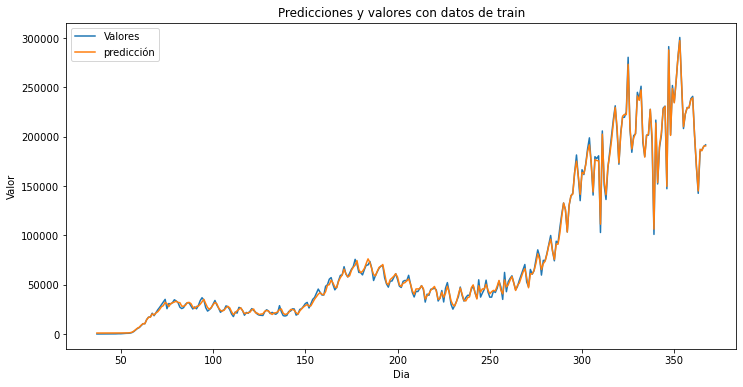

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(Xtrain.index,ytrain)
plt.plot(Xtrain.index,ytrain_pred)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de train')
plt.show()

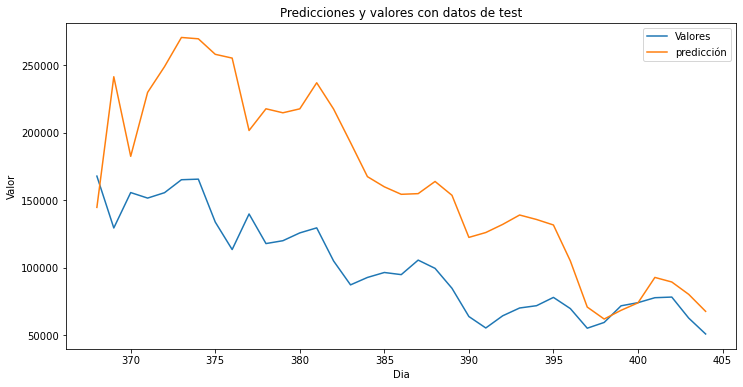

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(Xtest.index,ytest)
plt.plot(Xtest.index,ypred)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de test')
plt.show()

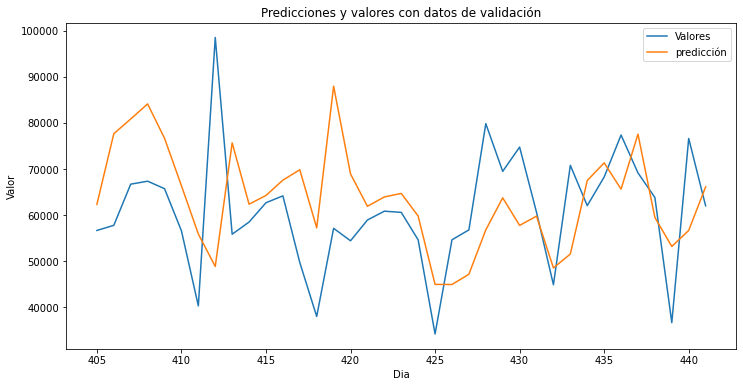

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(Xvalid.index,yvalid)
plt.plot(Xvalid.index,yvalidado)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de validación')
plt.show()

### WINDOW_SIZE DE 74

In [31]:
WINDOW_SIZE = 74
HORIZON = 1

df = pd.DataFrame(serie_temporal_covid19_casos, columns = ['Valor'])
df_windowed = df.copy()

list_cols = list(df.columns)
for i in range(1,WINDOW_SIZE+HORIZON):
    
    list_cols.append(list_cols[0]+'-'+str(i))

    df_windowed = pd.concat([df_windowed, df.shift(i)], axis=1)
    
list_cols = ['Target'] + list_cols
list_cols.pop(len(list_cols)-1)
df_windowed.columns = list_cols
df_windowed.dropna(axis=0,inplace=True)

df_windowed.head()

,Target,Valor,Valor-1,Valor-2,Valor-3,Valor-4,Valor-5,Valor-6,Valor-7,Valor-8,...,Valor-64,Valor-65,Valor-66,Valor-67,Valor-68,Valor-69,Valor-70,Valor-71,Valor-72,Valor-73
74,35099,32318.0,29717.0,26930.0,24506.0,21469.0,18520.0,21066.0,17330.0,16998.0,...,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0
75,25616,35099.0,32318.0,29717.0,26930.0,24506.0,21469.0,18520.0,21066.0,17330.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
76,30916,25616.0,35099.0,32318.0,29717.0,26930.0,24506.0,21469.0,18520.0,21066.0,...,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
77,30337,30916.0,25616.0,35099.0,32318.0,29717.0,26930.0,24506.0,21469.0,18520.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
78,31820,30337.0,30916.0,25616.0,35099.0,32318.0,29717.0,26930.0,24506.0,21469.0,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0


In [32]:
X = df_windowed.drop(columns = ['Target'], axis = 1)
y = df_windowed['Target']

In [33]:
len_valid = 37
len_test = len_valid

index_train = len(df_windowed) - len_valid - len_test + WINDOW_SIZE - 1
index_test = len(df_windowed) - len_valid + WINDOW_SIZE - 1

Xtrain, Xtest, Xvalid = X[X.index <= index_train], X[(X.index > index_train) & (X.index <= index_test)], X[X.index > index_test]
ytrain, ytest, yvalid = y[y.index <= index_train], y[(y.index > index_train) & (y.index <= index_test)], y[y.index > index_test]

modelo = GradientBoostingRegressor(random_state=0)
    
modelo.fit(Xtrain, ytrain)
ytrain_pred = modelo.predict(Xtrain)
ypred = modelo.predict(Xtest)
yvalidado = modelo.predict(Xvalid)
print('Predicciones',ypred)
print('Score', modelo.score(Xtrain, ytrain))
print('R2 Score valores predict', r2_score(ypred, ytest))
print('R2 Score valores validación', r2_score(yvalidado, yvalid))
print('mse test', mse(ypred, ytest))
print('mae test', mae(ypred, ytest))
print('mse valid', mse(yvalidado, yvalid))
print('mae valid', mae(yvalidado, yvalid))

Predicciones [126743.47551647 238857.60397687 176180.85246173 206661.18268494
 240392.1408974  266292.14481135 267861.13790381 252355.11543402
 236375.61484273 201640.07271519 219819.72807505 218570.57977738
 211107.1580722  233172.02634317 216086.13902944 195144.10052685
 189882.71284745 176836.2173488  176836.2173488  179311.77021801
 175022.36869941 183744.07872783 126238.32648395 133252.76495295
 139550.78216851 149325.55498129 168413.61735643 149812.69587547
 120365.57828249  77794.7279401   69907.15360437  76503.6689099
  80952.54118187  97704.76152075  91365.75898027  87893.96898554
  67097.43833215]
Score 0.9990117647485252
R2 Score valores predict -0.7354646056943344
R2 Score valores validación -1.814217985838349
mse test 6067875978.105893
mae test 69330.4007238369
mse valid 258396185.9797373
mae valid 13785.75608025333


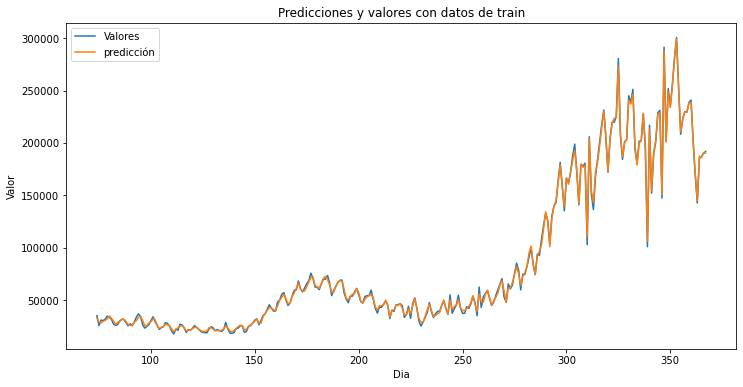

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(Xtrain.index,ytrain)
plt.plot(Xtrain.index,ytrain_pred)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de train')
plt.show()

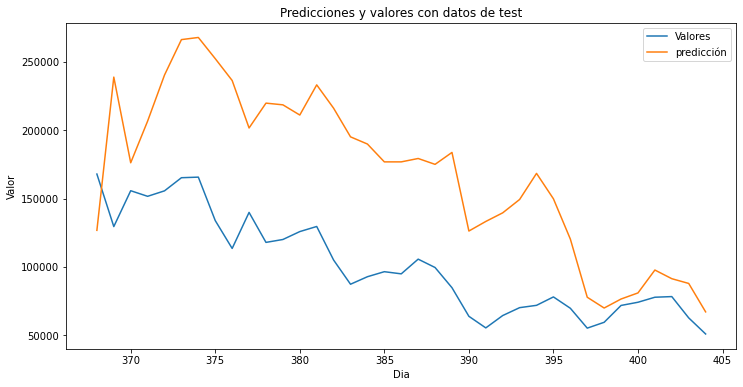

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(Xtest.index,ytest)
plt.plot(Xtest.index,ypred)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de test')
plt.show()

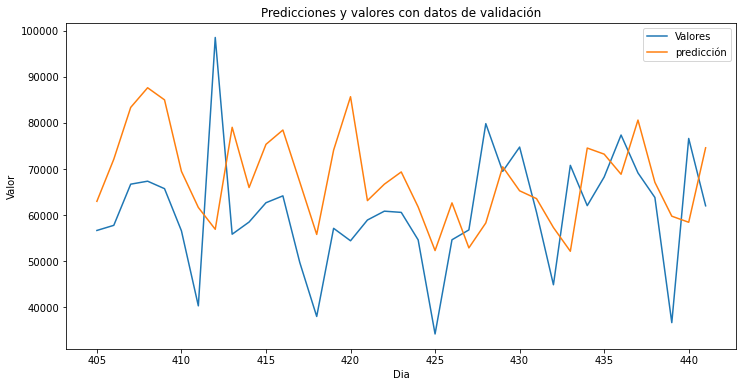

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(Xvalid.index,yvalid)
plt.plot(Xvalid.index,yvalidado)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de validación')
plt.show()

### WINDOW_SIZE DE 147

In [37]:
WINDOW_SIZE = 147
HORIZON = 1

df = pd.DataFrame(serie_temporal_covid19_casos, columns = ['Valor'])
df_windowed = df.copy()

list_cols = list(df.columns)
for i in range(1,WINDOW_SIZE+HORIZON):
    
    list_cols.append(list_cols[0]+'-'+str(i))

    df_windowed = pd.concat([df_windowed, df.shift(i)], axis=1)
    
list_cols = ['Target'] + list_cols
list_cols.pop(len(list_cols)-1)
df_windowed.columns = list_cols
df_windowed.dropna(axis=0,inplace=True)

df_windowed.head()

,Target,Valor,Valor-1,Valor-2,Valor-3,Valor-4,Valor-5,Valor-6,Valor-7,Valor-8,...,Valor-137,Valor-138,Valor-139,Valor-140,Valor-141,Valor-142,Valor-143,Valor-144,Valor-145,Valor-146
147,24885,20117.0,19130.0,25334.0,25493.0,23202.0,22852.0,18805.0,18207.0,18616.0,...,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0
148,25655,24885.0,20117.0,19130.0,25334.0,25493.0,23202.0,22852.0,18805.0,18207.0,...,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
149,28059,25655.0,24885.0,20117.0,19130.0,25334.0,25493.0,23202.0,22852.0,18805.0,...,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0
150,30836,28059.0,25655.0,24885.0,20117.0,19130.0,25334.0,25493.0,23202.0,22852.0,...,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
151,32025,30836.0,28059.0,25655.0,24885.0,20117.0,19130.0,25334.0,25493.0,23202.0,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0


In [38]:
X = df_windowed.drop(columns = ['Target'], axis = 1)
y = df_windowed['Target']

In [39]:
len_valid = 37
len_test = len_valid

index_train = len(df_windowed) - len_valid - len_test
index_test = len(df_windowed) - len_valid

Xtrain, Xtest, Xvalid = X[X.index <= index_train], X[(X.index > index_train) & (X.index <= index_test)], X[X.index > index_test]
ytrain, ytest, yvalid = y[y.index <= index_train], y[(y.index > index_train) & (y.index <= index_test)], y[y.index > index_test]

modelo = GradientBoostingRegressor(random_state=0)
    
modelo.fit(Xtrain, ytrain)
ytrain_pred = modelo.predict(Xtrain)
ypred = modelo.predict(Xtest)
yvalidado = modelo.predict(Xvalid)
print('Predicciones',ypred)
print('Score', modelo.score(Xtrain, ytrain))
print('R2 Score valores predict', r2_score(ypred, ytest))
print('R2 Score valores validación', r2_score(yvalidado, yvalid))
print('mse test', mse(ypred, ytest))
print('mae test', mae(ypred, ytest))
print('mse valid', mse(yvalidado, yvalid))
print('mae valid', mae(yvalidado, yvalid))

Predicciones [41658.59317824 39675.65491697 38252.9680227  42545.01189183
 39138.4692004  44197.49721524 47679.47754162 39112.52758785
 39616.52000488 41361.91451589 42671.01176182 45159.07170076
 48266.7039001  45164.71446035 41655.94908608 42170.44763417
 45153.96469542 46301.68337613 45761.09320761 48356.16140324
 49413.16754107 45185.24784943 45148.68236448 55019.38824382
 48598.31060394 49267.30657894 49307.61651623 59291.65126262
 48509.92510577 49469.53253224 49828.19540706 49773.26796774
 50116.99509311 53247.48731235 59144.70440395 52970.81053797
 50680.23354648]
Score 0.9999867557742685
R2 Score valores predict -2.071324470878899
R2 Score valores validación -952.1843174696219
mse test 82271265.4684221
mae test 7937.343973142255
mse valid 8950064374.538832
mae valid 69034.92463265466


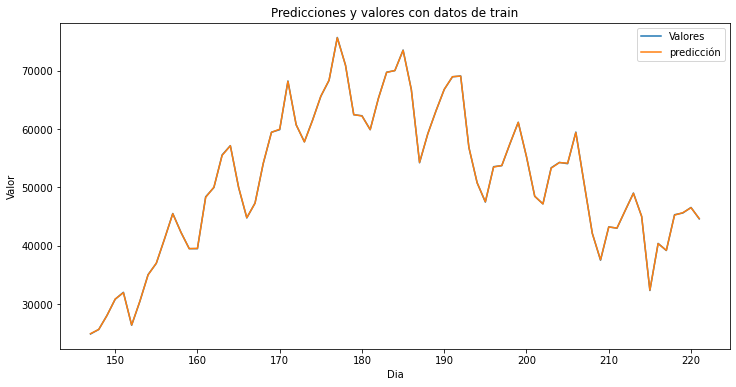

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(Xtrain.index,ytrain)
plt.plot(Xtrain.index,ytrain_pred)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de train')
plt.show()

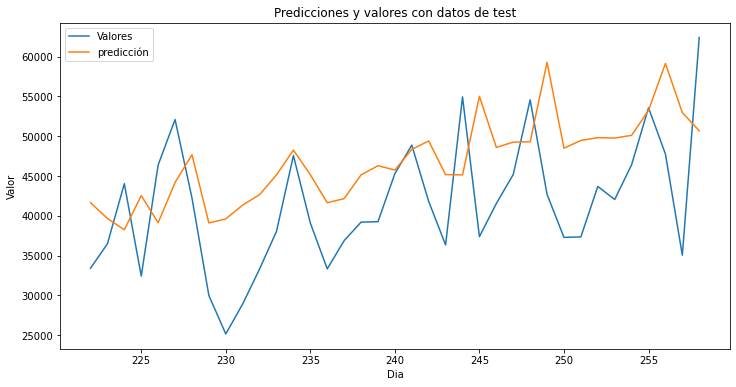

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(Xtest.index,ytest)
plt.plot(Xtest.index,ypred)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de test')
plt.show()

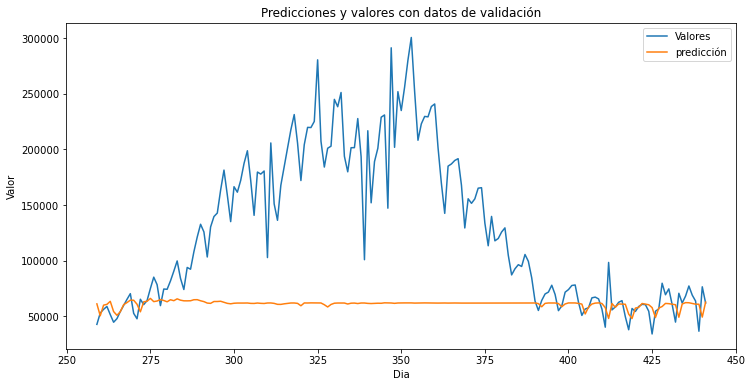

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(Xvalid.index,yvalid)
plt.plot(Xvalid.index,yvalidado)
plt.legend(['Valores','predicción'])
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.title('Predicciones y valores con datos de validación')
plt.show()

## 4.2 ARIMA

### Ya sabemos que la serie no es estacionaria, por lo que le daremos estacionalidad aplicando la diferencia de un ciclo comparativo (Homologo) de la serie.

In [45]:
def plot_series(time, series, format="-", start=0, end=None):
    """Permite pintar una serie según eje x (tiempo) e y (series) 
      con punto de inicio y fin"""
      
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Tiempo")
    plt.ylabel("Valor")
    plt.grid(True)

In [277]:
# mantenemos el tamaño de los datos de test y valid 
len_valid = 37
len_test = len_valid
total = len_valid+len_test
# Modificamos temporalmente la serie temporal para reservar los datos de validación
st_covid19_casos_sin_valid = serie_temporal_covid19_casos[0:-len_valid]

### ciclo de 37 dias

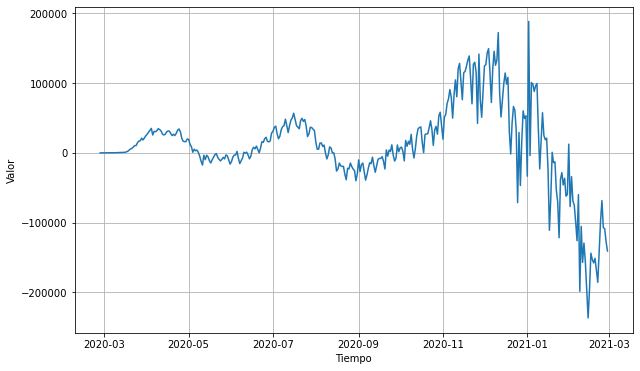

In [279]:
serie_temporal_covid19_casos_time = np.array(covid19_casos['Fecha'])
st_covid19_casos_sin_valid_time = serie_temporal_covid19_casos_time[0:-len_valid]

diff_series = (st_covid19_casos_sin_valid[37:] - st_covid19_casos_sin_valid[:-37]) 
diff_time = st_covid19_casos_sin_valid_time[37:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)


To check Stationary 


Before difference mean and Variance

mean1 = 10602.391304 ,mean2 = 9735.347826
var1 = 369999977.325142 ,var2 = 6926413701.074669


/Users/juanpablocarranza/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


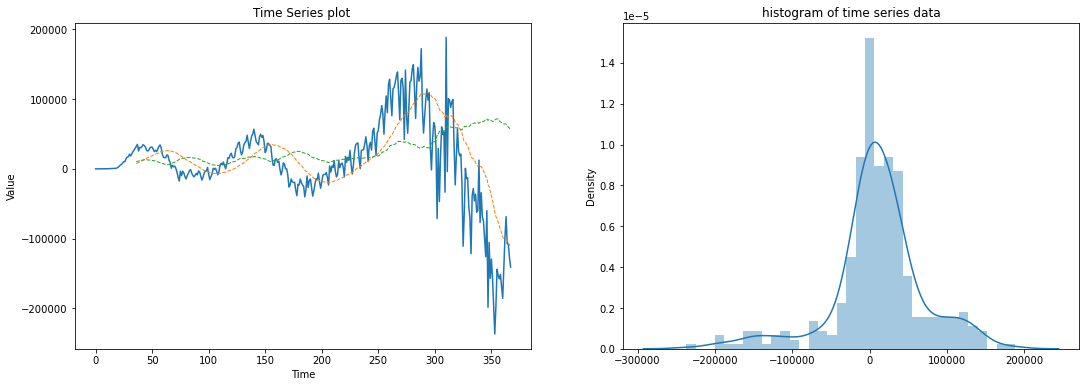

In [280]:
split = round(len(diff_series)/2)

X1,X2 = diff_series[0:split],diff_series[split:]
mean1 ,mean2 = X1.mean() , X2.mean()
var1,var2 = X1.var() , X2.var()

print("\033[1m" + "\nTo check Stationary \n" +  "\033[0m")
print("\nBefore difference mean and Variance\n")
print("mean1 = %f ,mean2 = %f" %(mean1,mean2))
print("var1 = %f ,var2 = %f" %(var1,var2))

fig ,ax = plt.subplots(1,2,figsize = (18,6))
plt.title("histogram of time series data")
ax[0].plot(diff_series)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].set_title("Time Series plot ")
sns.distplot(diff_series,ax =ax[1])

df_series = pd.DataFrame(diff_series, columns=['value'])
mean_12 = df_series['value'].rolling(37).mean()
std_12 = df_series['value'].rolling(37).std()
ax[0].plot(mean_12,'--', linewidth=1, label='mean')
ax[0].plot(std_12,'--', linewidth=1, label='std')

### ciclo de 74 dias

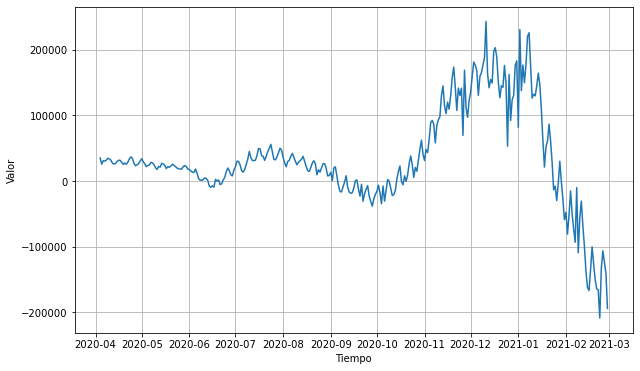

In [281]:
diff_series = (st_covid19_casos_sin_valid[74:] - st_covid19_casos_sin_valid[:-74]) 
diff_time = st_covid19_casos_sin_valid_time[74:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)


To check Stationary 


Before difference mean and Variance

mean1 = 21145.445783 ,mean2 = 47377.406061
var1 = 228621010.210916 ,var2 = 10298832155.998751


/Users/juanpablocarranza/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


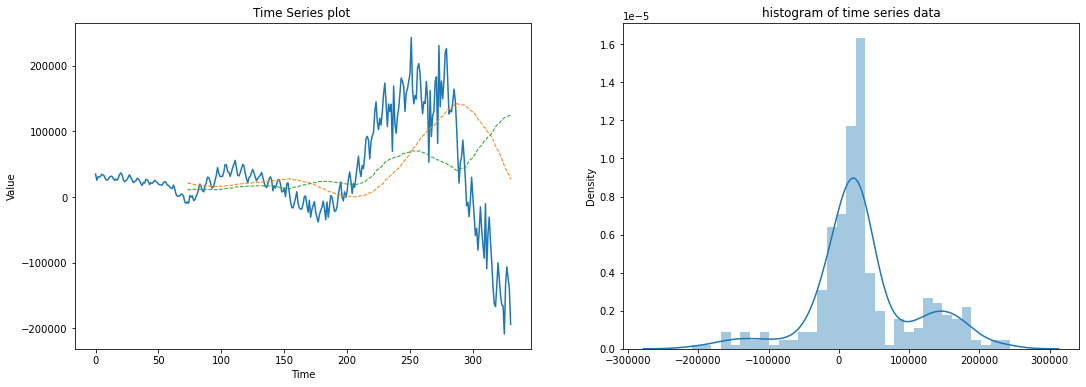

In [282]:
split = round(len(diff_series)/2)

X1,X2 = diff_series[0:split],diff_series[split:]
mean1 ,mean2 = X1.mean() , X2.mean()
var1,var2 = X1.var() , X2.var()

print("\033[1m" + "\nTo check Stationary \n" +  "\033[0m")
print("\nBefore difference mean and Variance\n")
print("mean1 = %f ,mean2 = %f" %(mean1,mean2))
print("var1 = %f ,var2 = %f" %(var1,var2))

fig ,ax = plt.subplots(1,2,figsize = (18,6))
plt.title("histogram of time series data")
ax[0].plot(diff_series)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].set_title("Time Series plot ")
sns.distplot(diff_series,ax =ax[1])

df_series = pd.DataFrame(diff_series, columns=['value'])
mean_12 = df_series['value'].rolling(74).mean()
std_12 = df_series['value'].rolling(74).std()
ax[0].plot(mean_12,'--', linewidth=1, label='mean')
ax[0].plot(std_12,'--', linewidth=1, label='std')

### ciclo de 147 dias

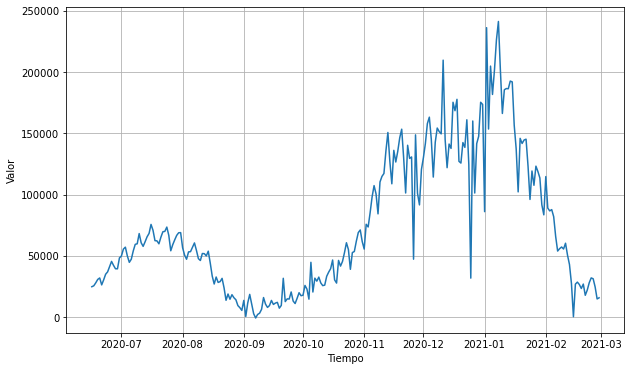

In [283]:
diff_series = (st_covid19_casos_sin_valid[147:] - st_covid19_casos_sin_valid[:-147]) 
diff_time = st_covid19_casos_sin_valid_time[147:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)


Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 35833.062016 ,mean2 = 111851.604651
var1 = 419437154.833363 ,var2 = 2906011671.045249


/Users/juanpablocarranza/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


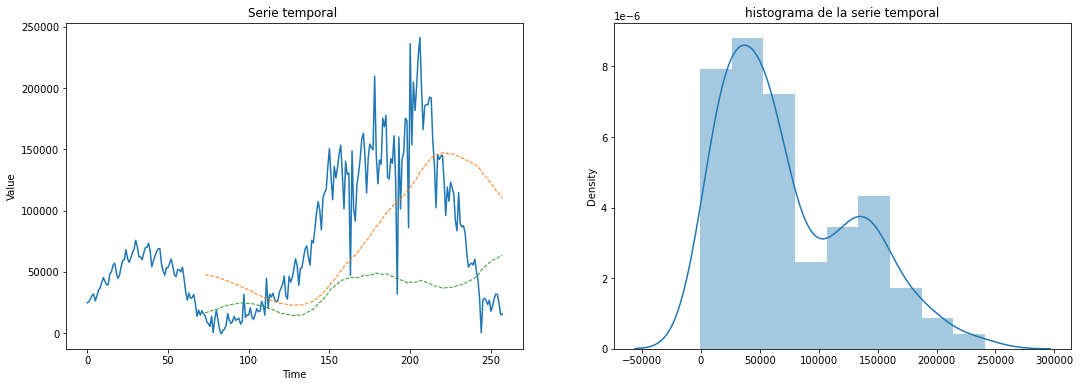

In [284]:
split = round(len(diff_series)/2)

X1,X2 = diff_series[0:split],diff_series[split:]
mean1 ,mean2 = X1.mean() , X2.mean()
var1,var2 = X1.var() , X2.var()

print("\033[1m" + "\nPara chequear estacionalidad \n" +  "\033[0m")
print("\nantes se debe verificar las medias y las varianzas\n")
print("mean1 = %f ,mean2 = %f" %(mean1,mean2))
print("var1 = %f ,var2 = %f" %(var1,var2))

fig ,ax = plt.subplots(1,2,figsize = (18,6))
plt.title("histograma de la serie temporal")
ax[0].plot(diff_series)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Value")
ax[0].set_title("Serie temporal ")
sns.distplot(diff_series,ax =ax[1])

df_series = pd.DataFrame(diff_series, columns=['value'])
mean_12 = df_series['value'].rolling(74).mean()
std_12 = df_series['value'].rolling(74).std()
ax[0].plot(mean_12,'--', linewidth=1, label='mean')
ax[0].plot(std_12,'--', linewidth=1, label='std')

<b> Al intentar con ciclos de dias parecidos a los de xgboost, no conseguimos una condición de estacionalidad al aplicar la diferencia de la serie con la porción de dias elegida. Por lo que realizaremos un barrido de cantidad de dias a restar (para obtener la diferencia en la serie) para ver cual podria ser una opción para convertir nuestra serie a estacional.

In [285]:
dias = []
media1 = []
media2 = []
p_value = []
for i in range(5,len(st_covid19_casos_sin_valid)-5,5):
    
    print("\033[1m" + '\nEvaluación de conversión de estacionalidad para ciclo de', i, 'dias')
# Generación de la resta de las series para intentar convertir a estacional

    diff_series = (st_covid19_casos_sin_valid[i:] - st_covid19_casos_sin_valid[:-i]) 
    diff_time = st_covid19_casos_sin_valid_time[i:]

# Calculo de las medias y las varianzas segun la partición realizada

    split = round(len(diff_series)/2)

    X1,X2 = diff_series[0:split],diff_series[split:]
    mean1 ,mean2 = X1.mean() , X2.mean()
    var1,var2 = X1.var() , X2.var()
    print("\033[1m" + "\nPara chequear estacionalidad \n" +  "\033[0m")
    print("\nantes se debe verificar las medias y las varianzas\n")
    print("mean1 = %f ,mean2 = %f, mean1/mean2 = %f" %(mean1,mean2,mean1/mean2))
    print("var1 = %f ,var2 = %f, var1/var2 = %f" %(var1,var2,var1/var2))

# Calculo del p-value

    result = adfuller(diff_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    print('----------------------------------------------------------------')
    print('')
    dias.append(i)
    media1.append(mean1)
    media2.append(mean2)
    p_value.append(result[1])


Evaluación de conversión de estacionalidad para ciclo de 5 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 1292.625000 ,mean2 = 426.440000, mean1/mean2 = 3.031200
var1 = 39675673.604375 ,var2 = 1044412242.926400, var1/var2 = 0.037989
ADF Statistic: -3.320062
p-value: 0.014005
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 10 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 2734.717172 ,mean2 = 693.197970, mean1/mean2 = 3.945074
var1 = 84633242.889705 ,var2 = 1822239661.153702, var1/var2 = 0.046445
ADF Statistic: -2.585472
p-value: 0.096037
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 15 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 3978.897436 ,mean2 = 1168.256410, mean1/mean2 = 3.40

ADF Statistic: -1.488265
p-value: 0.539308
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 165 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 40470.116667 ,mean2 = 119145.516667, mean1/mean2 = 0.339670
var1 = 416122369.619722 ,var2 = 3047746870.583055, var1/var2 = 0.136534
ADF Statistic: -1.022143
p-value: 0.745103
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 170 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 41561.135593 ,mean2 = 121212.418803, mean1/mean2 = 0.342879
var1 = 391150930.761275 ,var2 = 3205395767.439988, var1/var2 = 0.122029
ADF Statistic: -1.038811
p-value: 0.738847
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 175 dias

Para chequear estacio

ADF Statistic: -1.527259
p-value: 0.519986
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 375 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 109809.133333 ,mean2 = 66912.800000, mean1/mean2 = 1.641078
var1 = 285379738.248889 ,var2 = 73695772.560000, var1/var2 = 3.872403
ADF Statistic: -1.381985
p-value: 0.590882
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 380 dias

Para chequear estacionalidad 


antes se debe verificar las medias y las varianzas

mean1 = 95094.666667 ,mean2 = 68037.307692, mean1/mean2 = 1.397684
var1 = 424351372.555556 ,var2 = 72808698.828402, var1/var2 = 5.828306
ADF Statistic: -7.279837
p-value: 0.000000
----------------------------------------------------------------


Evaluación de conversión de estacionalidad para ciclo de 385 dias

Para chequear estacionalid

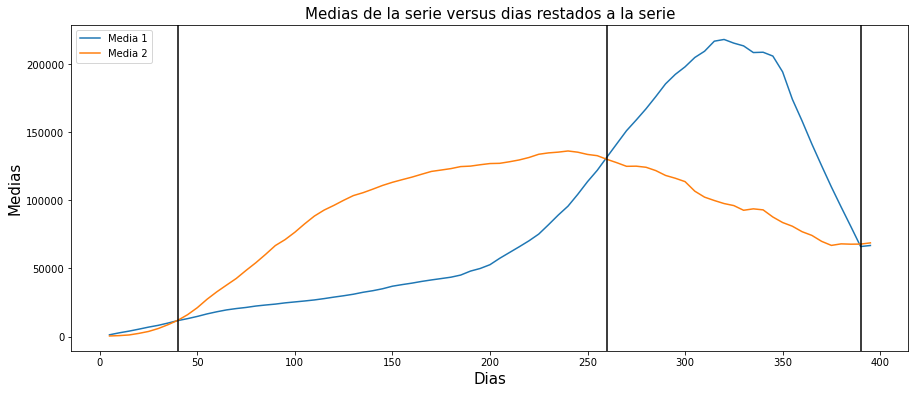

In [286]:
plt.figure(figsize=(15, 6))
plt.plot(dias, media1)
plt.plot(dias, media2)
plt.legend(['Media 1','Media 2'])
plt.title('Medias de la serie versus dias restados a la serie', fontsize=15)
plt.ylabel('Medias', fontsize=15)
plt.xlabel('Dias', fontsize=15)
plt.axvline(x=40, ymin=0, ymax=1, color='black')
plt.axvline(x=260, ymin=0, ymax=1, color='black')
plt.axvline(x=390, ymin=0, ymax=1, color='black')
plt.show()

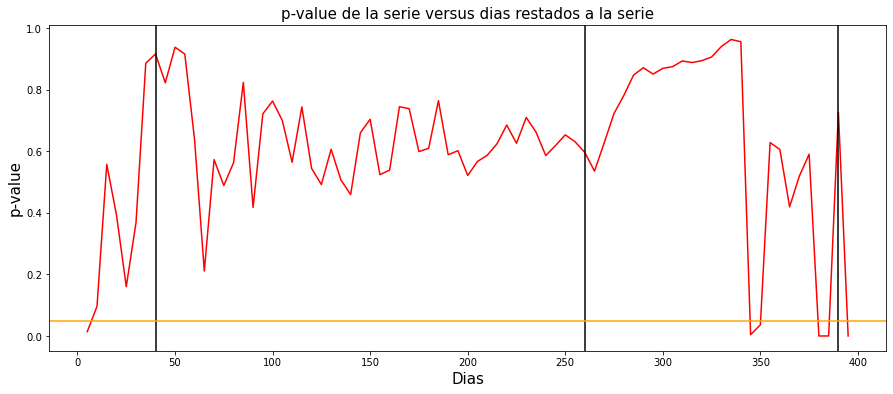

In [287]:
plt.figure(figsize=(15, 6))
plt.plot(dias, p_value, color = 'red')
plt.title('p-value de la serie versus dias restados a la serie', fontsize=15)
plt.ylabel('p-value', fontsize=15)
plt.xlabel('Dias', fontsize=15)
plt.axvline(x=40, ymin=0, ymax=1, color='black')
plt.axvline(x=260, ymin=0, ymax=1, color='black')
plt.axvline(x=390, ymin=0, ymax=1, color='black')
plt.axhline(y=0.05, xmin=0, xmax=1, color='orange')
plt.show()

<b> Al revisar variando la cantidad de dias para obtener la diferencia de la serie, se observa que las medias son mas cercanas (entre las divisiones de la serie) al tomar un cantidad cercana a 40 dias y a 390 dias (en los extremos). Por otro lado tambien se observa que en los extremos obtenemos p-values bajo el 0.05. Considerando estos antecedentes, se testeara crear un ARIMA, tomando un periodo 5 dias para generar la diferencia de las series. Esto para asi poder dejar mayor cantidad de datos en la serie que evaluar.

### 4.2.1 ARIMA realizando diferencia con una serie de 5 dias

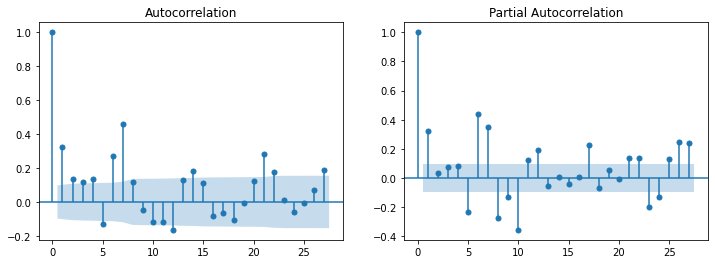

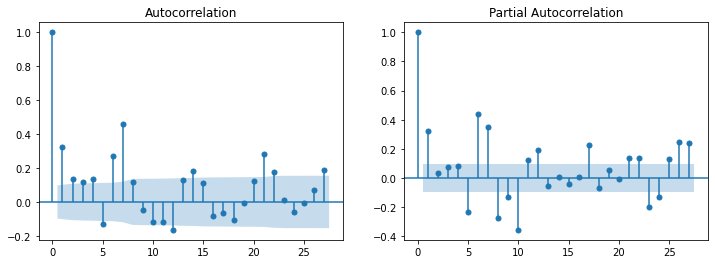

In [288]:
diff_series = (st_covid19_casos_sin_valid[5:] - st_covid19_casos_sin_valid[:-5]) 
diff_time = st_covid19_casos_sin_valid_time[5:]

fig ,ax = plt.subplots(1,2,figsize = (12,4))

plot_acf(diff_series, ax=ax[0])
plot_pacf(diff_series, ax=ax[1])

<b> Segun los graficos obtendriammos un p=6 y un q=2

In [289]:
# p=6,d=1,q=2 Modelo Arima
model = ARIMA(st_covid19_casos_sin_valid, order=(6,1,2))
results = model.fit()
print(results.summary())

/Users/juanpablocarranza/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  404
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -4464.060
Method:                       css-mle   S.D. of innovations          15197.787
Date:                Mon, 19 Apr 2021   AIC                           8948.119
Time:                        15:30:23   BIC                           8988.133
Sample:                             1   HQIC                          8963.959
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        160.1628    269.438      0.594      0.552    -367.925     688.251
ar.L1.D.y     -0.9221      0.139     -6.638      0.000      -1.194      -0.650
ar.L2.D.y     -0.9259      0.101     -9.142      0.0

/Users/juanpablocarranza/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<b> Evaluamos el modelo con datos de train, test y valid.

In [290]:
split = len(st_covid19_casos_sin_valid) - len_test


Xtrain = st_covid19_casos_sin_valid[:split]

Xtest = st_covid19_casos_sin_valid[split:]


<b> Datos TRAIN

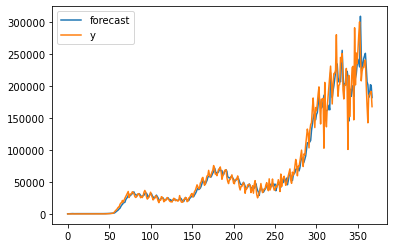

0.9745975397922491


In [291]:
y_train_pred = results.predict(end=split, dynamic=False)
results.plot_predict(end=split, dynamic=False)
plt.show()

y_train_pred = st_covid19_casos_sin_valid[:split] + y_train_pred

print(r2_score(Xtrain,y_train_pred))

<b> Datos TEST

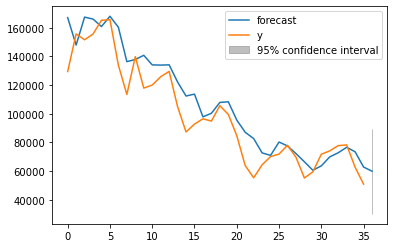

In [292]:
y_test_pred = results.predict(start=split+1, end=len(st_covid19_casos_sin_valid), dynamic=False)
results.plot_predict(start=split+1, end=len(st_covid19_casos_sin_valid), dynamic=False)
plt.show()

In [293]:
y_test_pred = st_covid19_casos_sin_valid[split:] + y_test_pred

In [294]:
r2_score(y_test_pred,Xtest)

0.9180735377949988

In [295]:
print('Error mse: ', mse(Xtest, y_test_pred))
print('Error mae: ', mae(Xtest, y_test_pred))

Error mse:  106947429.87790047
Error mae:  7906.187477446276


<b> Datos VALID (fuera del set de datos del modelo)

In [266]:
Xvalid = serie_temporal_covid19_casos[-len_valid-1:]

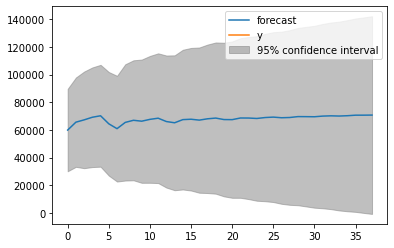

In [314]:
y_valid_pred = results.predict(start=len(st_covid19_casos_sin_valid), end=len(serie_temporal_covid19_casos), dynamic=False)
results.plot_predict(start=len(st_covid19_casos_sin_valid), end=len(serie_temporal_covid19_casos), dynamic=False)
plt.show()

In [304]:
y_valid_pred = serie_temporal_covid19_casos[len(st_covid19_casos_sin_valid)-1:len(serie_temporal_covid19_casos)] + y_valid_pred

In [305]:
r2_score(y_valid_pred,Xvalid)

0.962329676460452

In [307]:
print('Error mse: ', mse(Xvalid, y_valid_pred))
print('Error mae: ', mae(Xvalid, y_valid_pred))

Error mse:  5556404.123407247
Error mae:  1370.6048504987393


<AxesSubplot:>

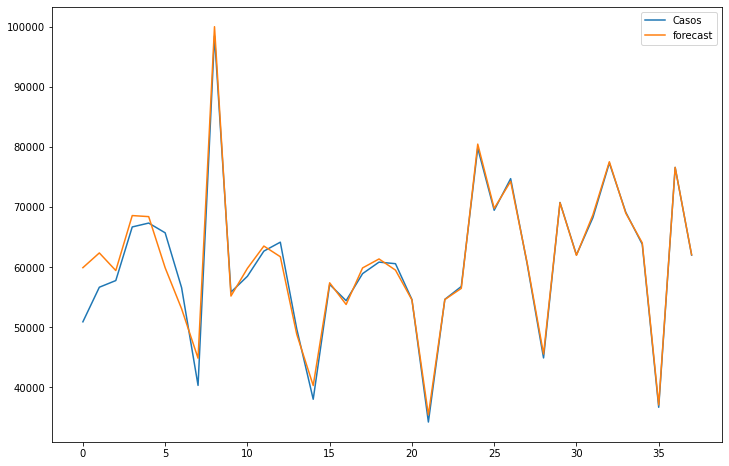

In [311]:
df= pd.DataFrame (Xvalid,columns=['Casos'])
df['forecast'] = results.predict(start=len(st_covid19_casos_sin_valid), end=len(serie_temporal_covid19_casos),dynamic=True)
df['forecast'] = serie_temporal_covid19_casos[len(st_covid19_casos_sin_valid)-1:len(serie_temporal_covid19_casos)] + df['forecast']
df[['Casos','forecast']].plot(figsize=(12,8))

### Ya habiendo realizado 2 modelos predicitivos de series temporales, el que mejores valores entrega es el de ARIMA (p=6,d=1,q=2 ademas considerando periodo homologos de 5 dias para la estacionalidad de los datos) entregando valores de "R2 Score" de 0.96 lo cual es un muy buen valor considerando que esta data no fue incorporada en el modelo para us entrenamiento. Ademas se obtuvo resultados de "R2 Score" en train y test de 0.97 y 0.92 respectivamente. El mse y el mae para los datos de validación no son despreciables pero tampoco es un gran valor considerando que los valores de casos en estos datos estan entre los 40.000 y 100.000 casos. En conclusión este es el modelo elegido para la predicción de datos a futuro.

# 5. Aplicación de predicción covid "StayHomeApp"

<b> Ya teniendo el modelo elegido, procedemos a generar predicciones para mas 7 dias al dia actual.

/Users/juanpablocarranza/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


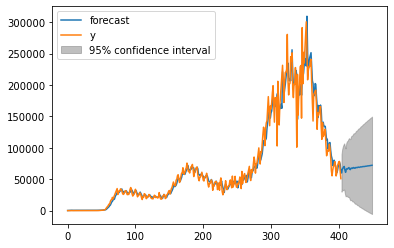

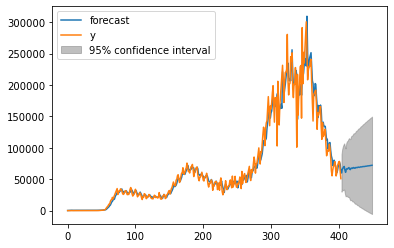

In [362]:
# p=6,d=1,q=2 Modelo Arima
model = ARIMA(st_covid19_casos_sin_valid, order=(6,1,2))
results = model.fit()

predicciones_futuras_casos_covid19 = results.predict(start=len(serie_temporal_covid19_casos)+1, end=len(serie_temporal_covid19_casos)+7+1, dynamic=False)
results.plot_predict(start=1,end=(len(serie_temporal_covid19_casos)+7+1), dynamic=False)

In [363]:
predicciones_7_dias = results.forecast(steps = 7) # Obtener valores de las predicciones a futuro

In [393]:
Fecha_futura = []
for i in range(len(predicciones_7_dias[0])):
    Fecha_futura.append(max(covid19_casos['Fecha'])+datetime.timedelta(days=i+1))
Fecha_futura

[Timestamp('2021-04-07 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-04-09 00:00:00'),
 Timestamp('2021-04-10 00:00:00'),
 Timestamp('2021-04-11 00:00:00'),
 Timestamp('2021-04-12 00:00:00'),
 Timestamp('2021-04-13 00:00:00')]

Text(0.5, 0, 'Dia')

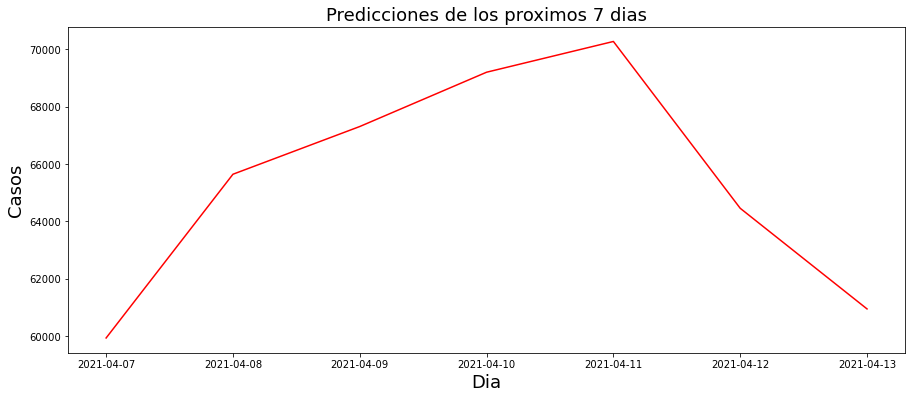

In [394]:
plt.figure(figsize=(15, 6))
plt.plot(Fecha_futura,predicciones_7_dias[0], color='red')
plt.title('Predicciones de los proximos 7 dias', fontsize = 18)
plt.ylabel('Casos', fontsize = 18)
plt.xlabel('Dia', fontsize = 18)

# 5. Conclusiones

<b> 1. La información referente a los casos de Covid-19 presentaron un desafio, ya que al momento de descomponer y revisar la serie temporal de estos datos, no se encontro estacionalidad, tendencia o ciclicidad. Esto lo hizo mas dificil al momento de poder concretar un modelo eficiente.
    
<b> 2. Al observar la evolución de los casos en el tiempo, se podia ver cierto comportamiento el cual uno podria identificar como las llamadas "Olas" de casos. Estas podrian haber ayudado a generar algun tipo de relación para ajustar el modelo, pero lamentablemente estas "Olas" no tenian siempre la misma duración, por lo que no se pudo obtener alguna estacionalidad que ayudase a mejorar los modelos.
    
<b>  3. El metodo con el modelo Xgboost se realizo para diferentes ventanas de datos (Windowings), pero ninguno obtuvo resultados optimos para utilizar para precicciones.
    
<b>  4. Para el metodo ARIMA, hubo complicaciones ya que la serie temporal no era estacionaria, por lo que se tuvo que buscar el intervalo de dias para poder acercar lo mas posible la serie temporal a una estacionaria, tomando como opción la de 5 dias.
    
<b>  5. Al generar el modelo ARIMA se encontro que el modelo se ajusto muy bien a los datos de test, train y Validación. Por eso mismo se escogio para producir predicciones a futuro en los casos de covid para la empresa "StayHome".